In [1]:
# Core scverse libraries
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [4]:
adata = sc.read_h5ad("../preprocessed/adatas/5k_pbmc_protein.h5ad", 'r')

In [8]:
sliced_5 = adata[: 5, : 100]

In [11]:
sliced_5
sliced_5.write("../preprocessed/adatas/500_pbmc_protein.h5ad")

In [ ]:
# Read adata
adata = sc.read_10x_h5(
    filename="filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546196",
)
adata

In [3]:
adata.var

,gene_ids,feature_types,genome,interval
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,chr1:29553-30267
FAM138A,ENSG00000237613,Gene Expression,GRCh38,chr1:36080-36081
OR4F5,ENSG00000186092,Gene Expression,GRCh38,chr1:65418-69055
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,chr1:120931-133723
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,chr1:91104-91105
...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,KI270728.1:1270983-1270984
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,KI270731.1:13000-13001
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,KI270734.1:72410-72411
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,KI270734.1:131493-131494


In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [6]:
adata.var.sample(5)

,gene_ids,feature_types,genome,interval
OCA2,ENSG00000104044,Gene Expression,GRCh38,chr15:28099311-28099315
TNRC18,ENSG00000182095,Gene Expression,GRCh38,chr7:5423545-5425414
B4GALT4-AS1,ENSG00000240254,Gene Expression,GRCh38,chr3:119226485-119226486
CSNK1G3,ENSG00000151292,Gene Expression,GRCh38,chr5:123512098-123545634
PYCR1,ENSG00000183010,Gene Expression,GRCh38,chr17:81936868-81937328


### Quality Control Metrics

1. number of genes per barcode
2. number of counts per barcode (count depth)
3. fraction of counts from mitochondrial genes per barcode.


In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
#ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


In [6]:
adata.var.mt

MIR1302-2HG    False
FAM138A        False
OR4F5          False
AL627309.1     False
AL627309.3     False
               ...  
AC141272.1     False
AC023491.2     False
AC007325.1     False
AC007325.4     False
AC007325.2     False
Name: mt, Length: 36601, dtype: bool

In [ ]:
# calculate the respective qc metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo", "hb"], 
    inplace=True, 
    percent_top=[20],
    log1p=True,
)
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

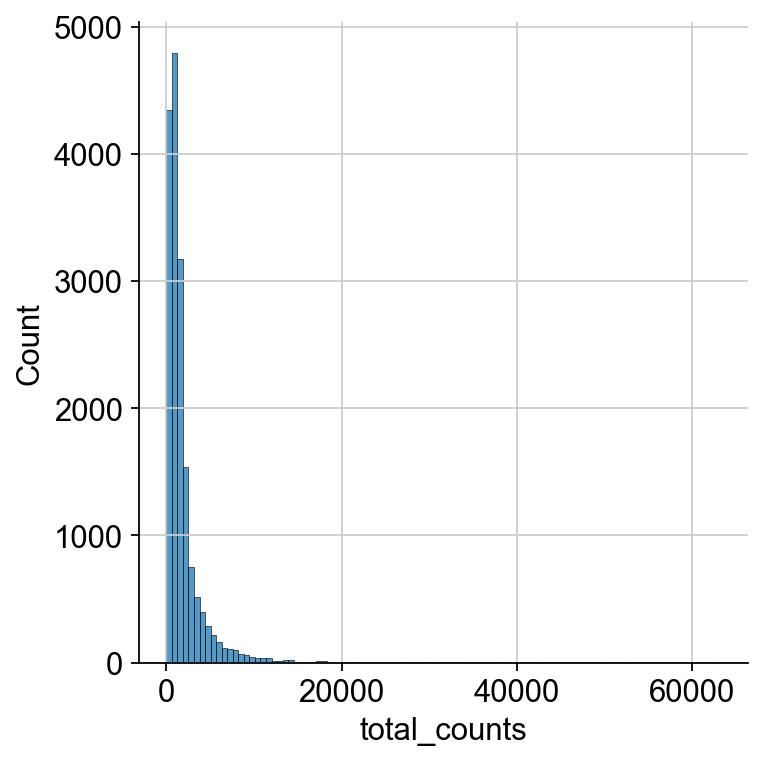

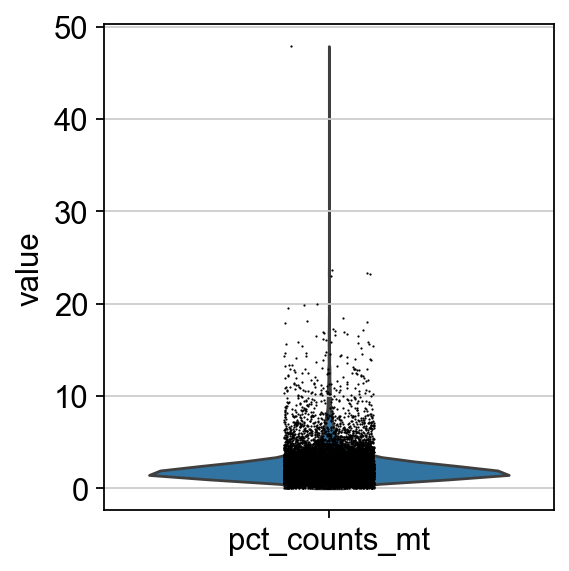

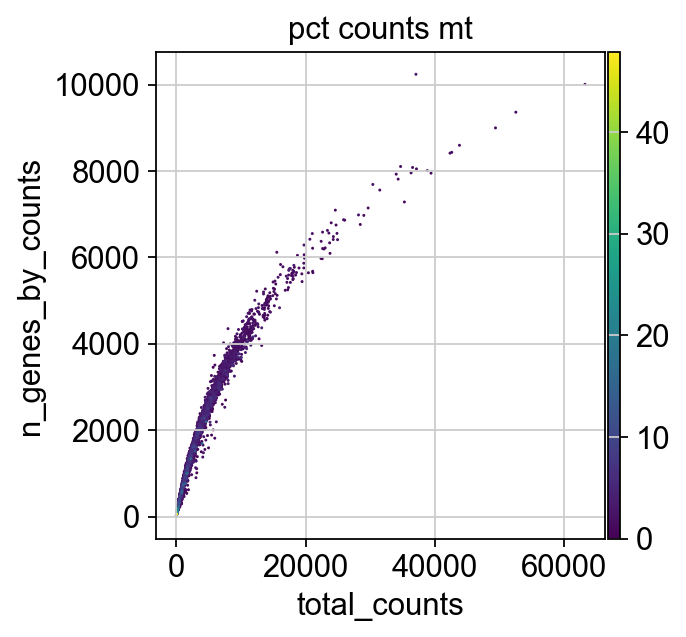

In [10]:
# plot the three qc covariates
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [11]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
               np.median(M) + nmads * median_abs_deviation(M) < M
               )
    return outlier


adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )

adata.obs.outlier.value_counts()


outlier
False    16065
True       869
Name: count, dtype: int64

In [ ]:
# Filter pct_counts_mt by 3MADs and cells with pct_counts_mt > 8%
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    15240
True      1694
Name: count, dtype: int64

In [13]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16934
Number of cells after filtering of low quality cells: 14814


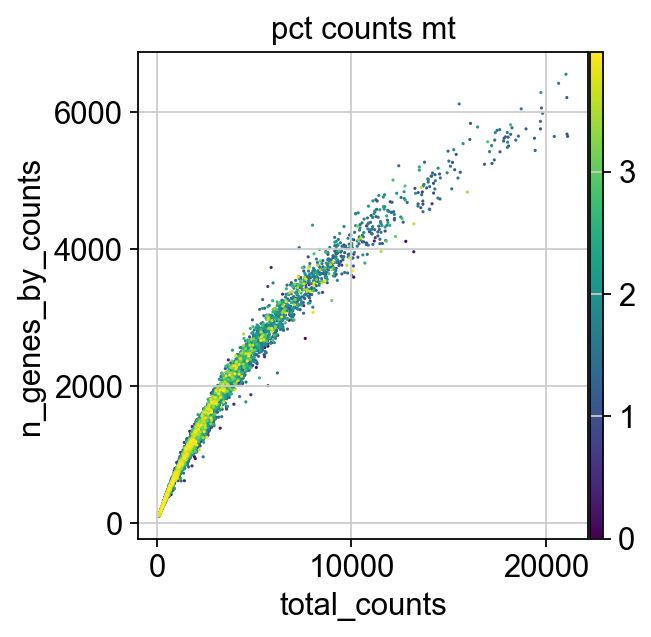

In [14]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Correction of ambient RNA

-   Using soupX


###


In [ ]:
import logging
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import rpy2.robjects.pandas2ri as rpd
from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
# 1. Suppress rpy2 warnings/messages (still necessary)
rcb.logger.setLevel(logging.ERROR)


In [ ]:
# from rpy2.robjects.packages import importr


# # Install required Bioconductor packages
# ro.r('''
# BiocManager::install(c("S4Vectors", "SingleCellExperiment", "SummarizedExperiment"))
# ''')

# # Install SoupX while we're at it
# ro.r('''
# if (!requireNamespace("SoupX", quietly = TRUE))
#     install.packages("SoupX")
# ''')



with localconverter(anndata2ri.converter):
    ro.globalenv['sce'] = adata

In [ ]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [ ]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]
del adata_pp

In [ ]:
# Save cells, genes, data tranposed
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [ ]:
adata_raw = sc.read_10x_h5(
    filename="raw_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546217",
)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

In [22]:
del adata_raw

In [ ]:
# put all data into R objects
with localconverter(anndata2ri.converter):
    ro.globalenv['data'] = data
    ro.globalenv['soupx_groups'] = soupx_groups
    ro.globalenv['cells'] = cells
    ro.globalenv['genes'] = genes
    ro.globalenv['data_tod'] = data_tod

# specify row and column names of data
r("""
 library(SoupX)
 library(SingleCellExperiment)

 # specify row and column names of data
 rownames(data) = genes
 colnames(data) = cells
 
 # ensure correct sparse format fortable of counts and table of droplets
 data <- as(data, "sparseMatrix")
 data_tod <- as(data, "sparseMatrix")

 # Generate SoupChannel Object for SoupX
 sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE) 

 # Add extra meta data to the soupChannel object
 soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
 sc = setSoupProfile(sc, soupProf)    
 # Set cluster information in SoupChannel
 sc = setClusters(sc, soupx_groups)
 
 # Estimate contamination fraction
 sc = autoEstCont(sc, doPlot=FALSE)
 # Infer corrected table of counts and round to integers
 out = adjustCounts(sc, roundToInt = TRUE)
""")



In [28]:
# convert data back to python
adata.layers['raw_counts'] = adata.X.copy()

with localconverter(anndata2ri.converter):
    corrected_counts = ro.globalenv['out']

adata.layers["soupX_counts"] = corrected_counts.T
adata.X = adata.layers["soupX_counts"]


In [29]:
# Filter out genes not detected in at least 20 cells
sc.pp.filter_genes(adata, min_cells=20)


### Doublet Detection


In [36]:
data_mat = adata.X.T
with localconverter(anndata2ri.converter):
    ro.globalenv['data_mat'] = data_mat
r("""
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)
  
set.seed(123)
sce = scDblFinder(
  SingleCellExperiment(
  list(counts=data_mat),
  )
  )
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class
""")

In [38]:
with localconverter(anndata2ri.converter):
    doublet_score = ro.globalenv["doublet_score"]
    doublet_class = ro.globalenv["doublet_class"]

adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
1    12159
2     2655
Name: count, dtype: int64

## Normalization


1. **shifted logarithm transformation** - works beneficial for stabilizing variance for subsequent dimensionality reduction, and identification of differenially expressed genes

2. **Scran** - extensively tested and used for batch effect correction tasks.

3. **Analytic Pearson residuals** - are well suited for selecting biologically variable genes and identification of rare cell types.


In [40]:
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import issparse

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)


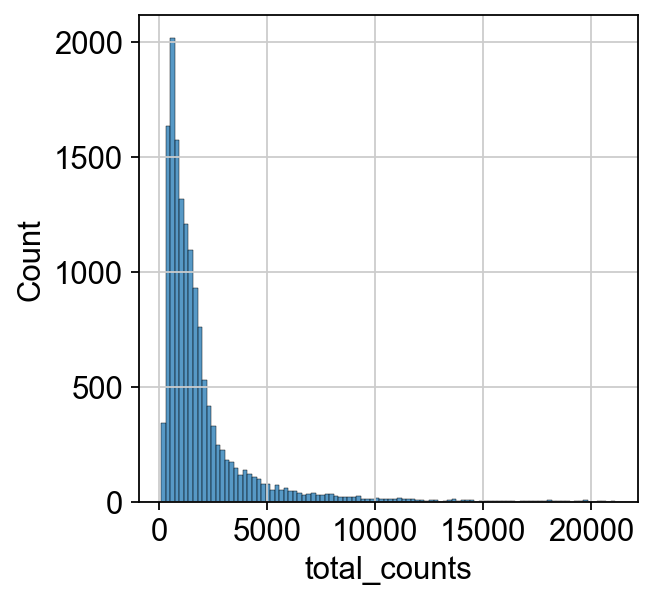

In [ ]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [ ]:
# shifted logarithm
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

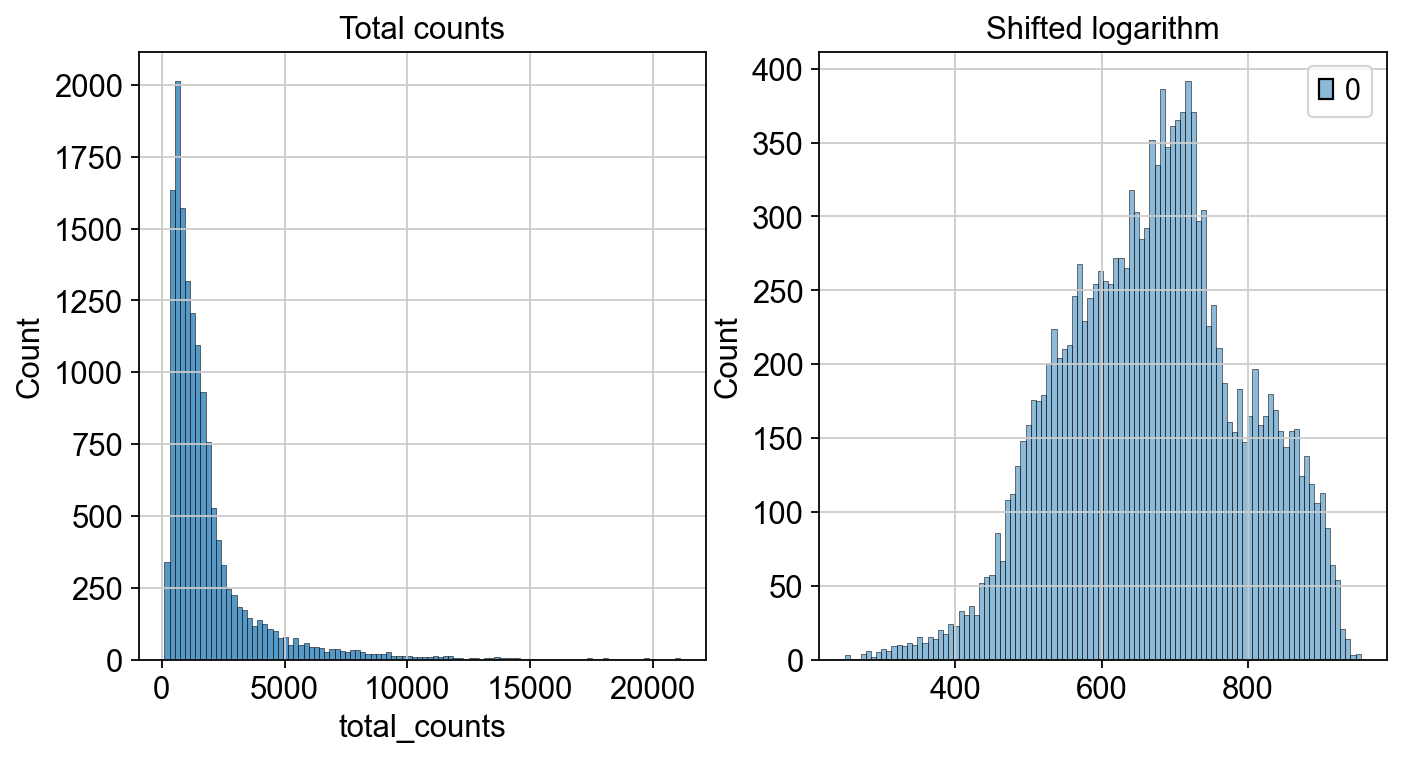

In [43]:
# inspect how distribution for count changed
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [47]:
## Scran
# Scran requires a coarse clustering input to improve size factor estimation performance.
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

# add data_mat and computed groups into r environment
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarionLab/scran/issues/70
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()

with localconverter(anndata2ri.converter):
    ro.globalenv["data_mat"] = data_mat
    ro.globalenv["input_groups"] = adata_pp.obs["groups"]

del adata_pp

from scipy.sparse import csr_matrix
r("""
  library(scran)
  library(BiocParallel)
  
  size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)),
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam(),
    )
  ) 
  """)

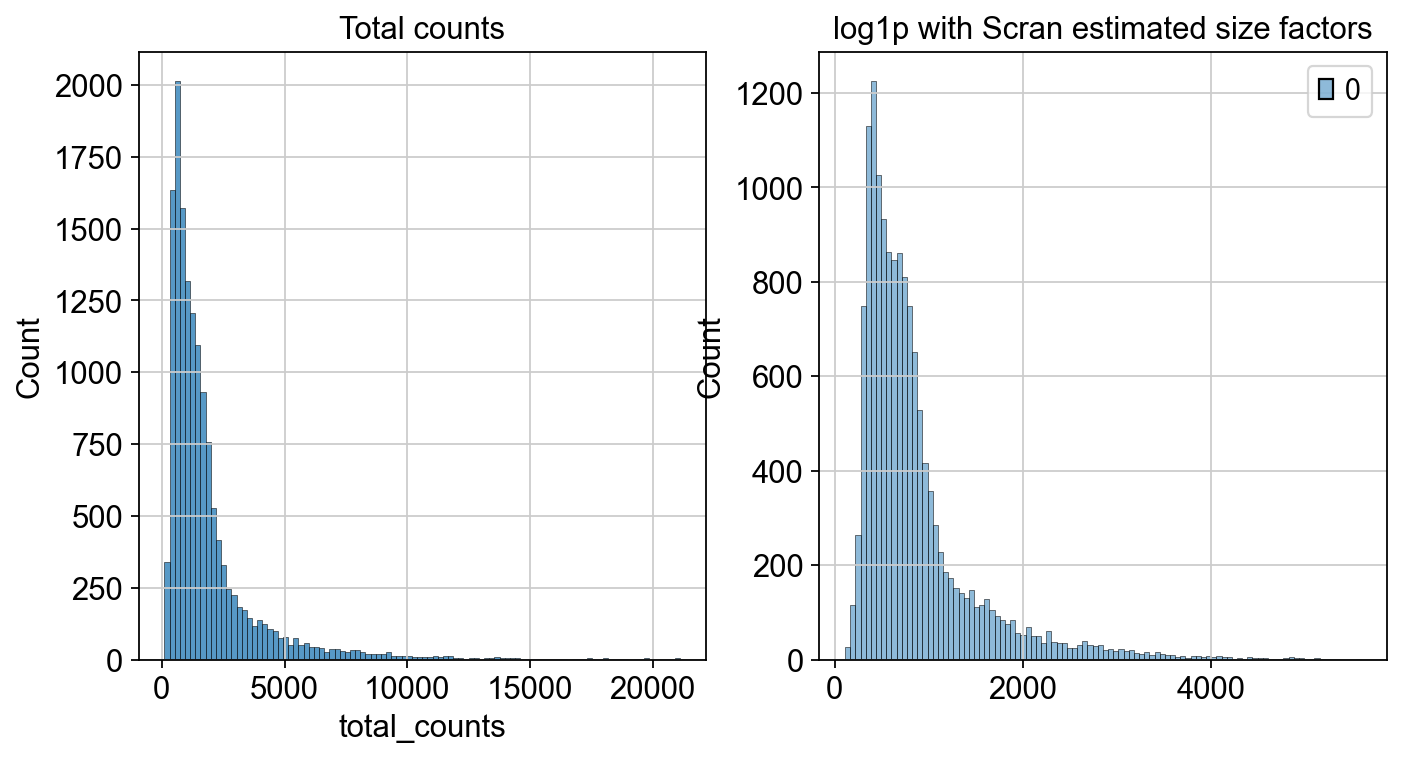

In [52]:
with localconverter(anndata2ri.converter):
    size_factors = ro.globalenv["size_factors"]

adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(np.log1p(scran))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1  = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

In [ ]:
### Analytic Pearson residuals
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])


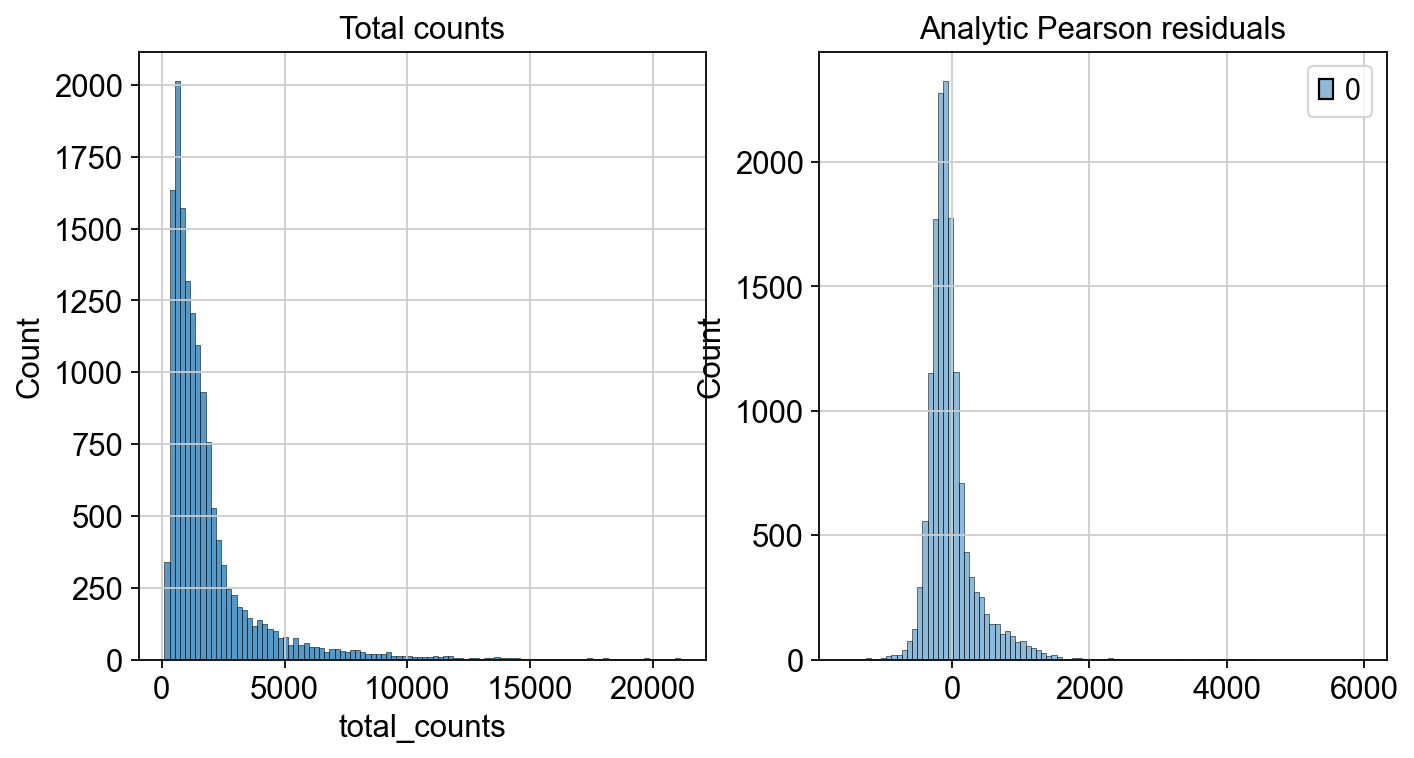

In [ ]:
"""fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)

axes[1].set_title("Analytic Pearson residuals")
plt.show()"""

## Feature Selection

-   Traditional approaches normally focus on (1) Coefficient of variation (highly variable genes) or (2) average expressed genes (highly expressed genes)

-   Features selection is highly sensitive to normalization method used.
-   Deviance is a recommended approach that select features based on raw counts.


In [66]:
## using the deviance approch to select features
## make an anndata with only the X values to save memory.
import anndata as ad
adata_copy = ad.AnnData(X=adata.X)
with localconverter(anndata2ri.converter):
    ro.globalenv["adata"] = adata_copy

r("""
  library(scry)
  sce = devianceFeatureSelection(adata, assay="X")
  binomial_deviance = rowData(sce)$binomial_deviance
""")
with localconverter(anndata2ri.converter):
    bin_dev = ro.globalenv["binomial_deviance"]

binomial_deviance = bin_dev.T

# select the 400 top highly deviant genes
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance


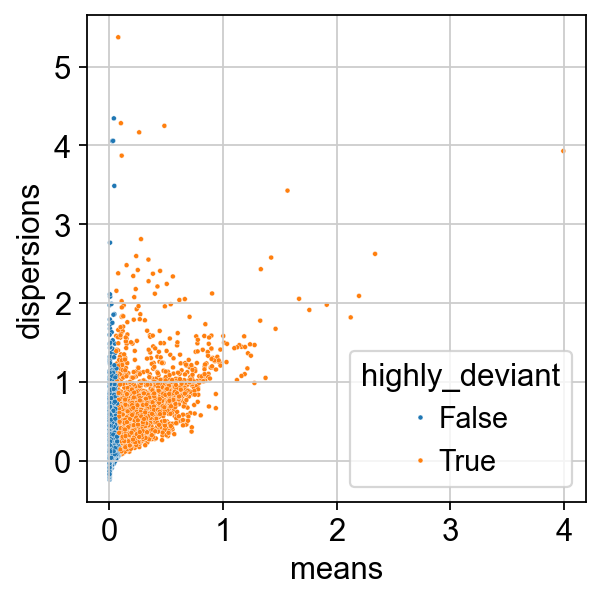

In [67]:
# visualize the feature selection result
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

# inspect result by plotting dispersion versus mean
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)

In [68]:
adata.write("s48_feature_selection_h5ad")

In [2]:
path = "/Users/maxwelladorsoo/Desktop/procupine/scGPT/data/datasets/brain/partition_0.h5ad"
adata = sc.read_h5ad(path)
adata


AnnData object with n_obs × n_vars = 200000 × 61888
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 444728996 stored elements and shape (200000, 61888)>